# **Piplene of Person Generation task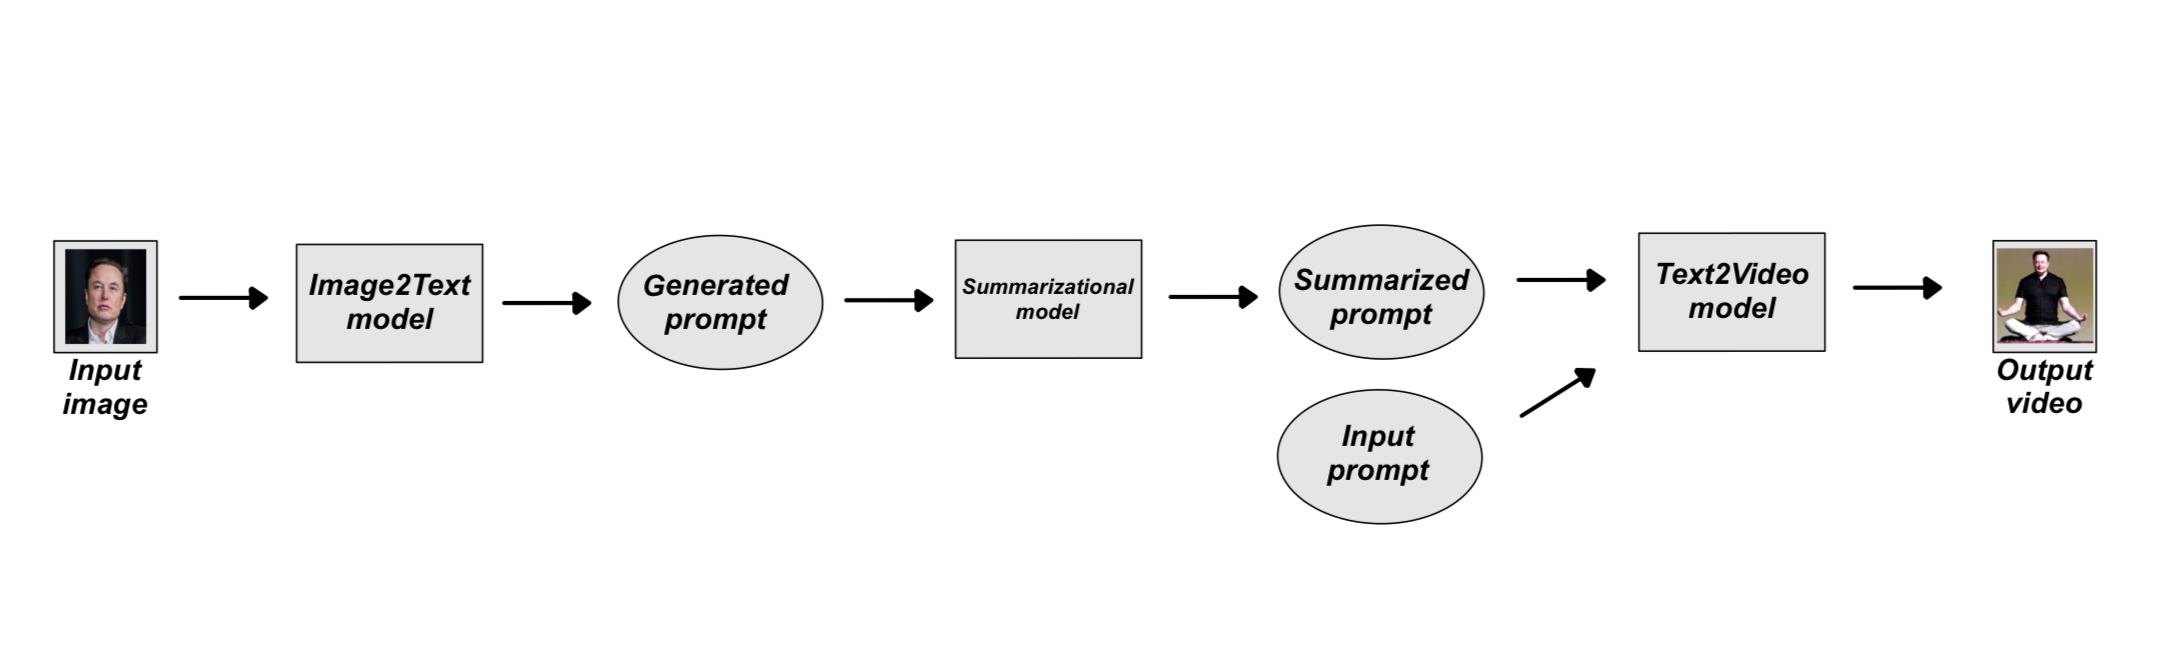**




---



1.   Downloading [SALT-NLP/Impressions](https://huggingface.co/datasets/SALT-NLP/Impressions) dataset from HuggingFace. This dataset includes faces and people, so we can shift the weights of our model a little more towards people's faces.
2.   Fine-tuning a [BLIP-2](https://huggingface.co/docs/transformers/v4.28.1/model_doc/blip-2) model on chosen dataset.
3.   After that the prompt, given by BLIP-2 we summarize with help of [text summarization](https://huggingface.co/Falconsai/text_summarization) model to make a shorter and more informative summarized prompt.
4.   Take a user input prompt and our generated prompt and combine them into a final prompt.
5.   Final prompt we put into [Text2Video](https://huggingface.co/docs/diffusers/api/pipelines/text_to_video_zero) model, which generates a video.



---



## **Installing the necessary dependencies**

PEFT is a library for efficiently adapting large pretrained models to various downstream applications without fine-tuning all of a model’s parameters. PEFT methods only fine-tune a small number of (extra) model parameters - significantly decreasing computational and storage costs - while yielding performance comparable to a fully fine-tuned model.

In [1]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


Diffusers is the go-to library for state-of-the-art pretrained diffusion models for generating images, audio, and even 3D structures of molecules.

In [2]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.2 MB/s eta 0:00:00


## **Importing dependencies**

In [3]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import imageio
from datasets import load_dataset
from transformers import AutoProcessor, Blip2ForConditionalGeneration, pipeline
from peft import LoraConfig, get_peft_model
from diffusers import TextToVideoZeroPipeline

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Current device = {device}")

Current device = cuda


## **Loading Image Captioning dataset**

The Impressions dataset is a multimodal benchmark that consists of 4,100 unique annotations and over 1,375 image-caption pairs from the photography domain. Each annotation explores (1) the aesthetic impactfulness of a photograph, (2) image descriptions in which pragmatic inferences are welcome, (3) emotions/thoughts/beliefs that the photograph may inspire, and (4) the aesthetic elements that elicited the expressed impression. But in our project we will be interseted only in caption. Maybe later I will create a super-prompt, based on emotions and etc.

If you want to look at the dataset sample, you can copy it, put your values in ***num*** and and ***column_name*** paste after dataset downloading: `dataset[num]["column_name"]`

In [5]:
dataset = load_dataset("SALT-NLP/Impressions", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1352 [00:00<?, ? examples/s]

## **Workflow with dataset**

In [6]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor


    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["caption"] = item["caption"]
        return encoding

def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key != "caption":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["caption"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [7]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.13981301102065136


In [9]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

## **Model fine-tuning**

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

model.train()

for epoch in range(7):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 5.859375
Loss: 5.55859375
Loss: 6.4375
Loss: 7.7421875
Loss: 4.06640625
Loss: 4.30859375
Loss: 4.45703125
Loss: 5.41015625
Loss: 3.806640625
Loss: 5.0
Loss: 4.12890625
Loss: 4.40234375
Loss: 4.17578125
Loss: 3.77734375
Loss: 5.42578125
Loss: 3.900390625
Loss: 3.96875
Loss: 3.841796875
Loss: 3.47265625
Loss: 3.390625
Loss: 3.25
Loss: 3.458984375
Loss: 2.619140625
Loss: 3.052734375
Loss: 3.40625
Loss: 3.267578125
Loss: 2.6640625
Loss: 3.248046875
Loss: 2.7734375
Loss: 2.958984375
Loss: 2.80078125
Loss: 3.11328125
Loss: 3.08984375
Loss: 2.984375
Loss: 2.490234375
Loss: 3.16015625
Loss: 3.21875
Loss: 3.09375
Loss: 2.4296875
Loss: 2.5390625
Loss: 2.94140625
Loss: 2.955078125
Loss: 2.646484375
Loss: 2.673828125
Loss: 2.439453125
Loss: 2.43359375
Loss: 3.234375
Loss: 3.279296875
Loss: 2.48828125
Loss: 2.287109375
Loss: 2.375
Loss: 3.005859375
Loss: 2.423828125
Loss: 2.51171875
Loss: 1.9638671875
Loss: 1.9736328125
Loss: 1.6455078125
Loss: 3.9609375
Loss: 2.2734375
Loss: 2.42382

In [11]:
torch.save(model.state_dict(), 'model_weights.pth')

### **How to download the model weights later?**

You only have to paste this:


```
my_loaded_model = TheModelClass(*args, **kwargs)
my_loaded_model.load_state_dict(torch.load('model_weights.pth'))
```





---



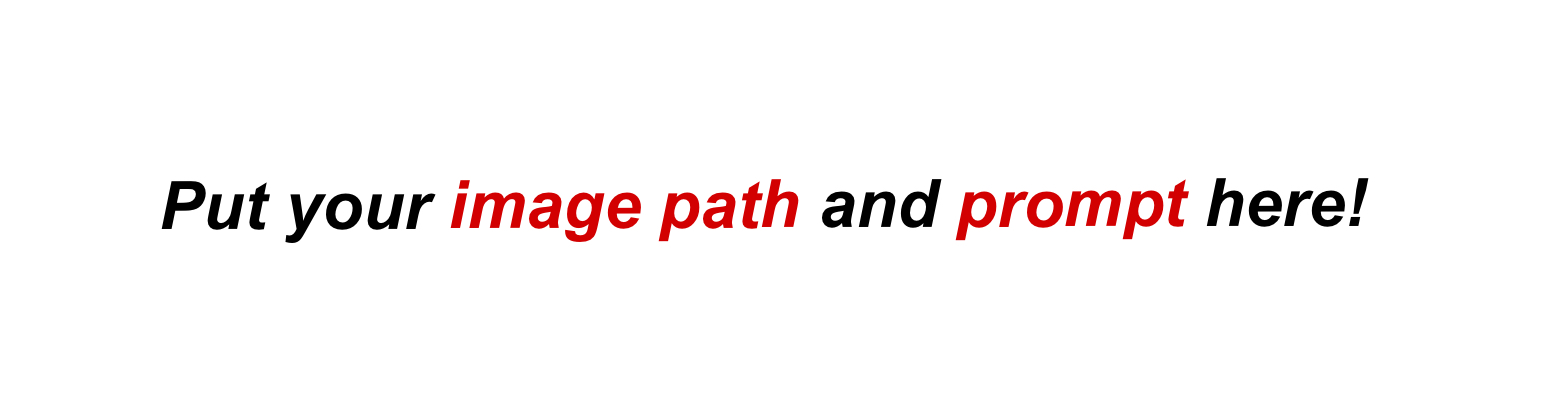

In [12]:
image_path = "/content/Elon_Musk_Colorado_2022_(cropped2).jpg"
user_prompt = "A man meditates in the lotus position, sitting on the sand"



---



## **Generating prompts for input image**

In [13]:
user_img = Image.open(image_path)

In [14]:
inputs = processor(images=user_img, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

Elon Musk is the world's most powerful man, and he is also the most controversial. His company, Tesla,


In [15]:
summarizer = pipeline("summarization", model="Falconsai/text_summarization")

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [16]:
summarizer_prompt = summarizer(generated_caption, max_length=6,
                               min_length=2, do_sample=False)[0]['summary_text']
summarizer_prompt

'Elon Musk is the'

In [17]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = TextToVideoZeroPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [18]:
prompt = summarizer_prompt + '. ' + user_prompt
prompt

'Elon Musk is the. A man meditates in the lotus position, sitting on the sand'

In [19]:
seed = 0
video_length = 24  #24 ÷ 4fps = 6 seconds
chunk_size = 8

# Generate the video chunk-by-chunk
result = []
chunk_ids = np.arange(0, video_length, chunk_size - 1)
generator = torch.Generator(device="cuda")
for i in range(len(chunk_ids)):
    print(f"Processing chunk {i + 1} / {len(chunk_ids)}")
    ch_start = chunk_ids[i]
    ch_end = video_length if i == len(chunk_ids) - 1 else chunk_ids[i + 1]
    # Attach the first frame for Cross Frame Attention
    frame_ids = [0] + list(range(ch_start, ch_end))
    # Fix the seed for the temporal consistency
    generator.manual_seed(seed)
    output = pipe(prompt=prompt, video_length=len(frame_ids), generator=generator, frame_ids=frame_ids)
    result.append(output.images[1:])

# Concatenate chunks and save
result = np.concatenate(result)
result = [(r * 255).astype("uint8") for r in result]
imageio.mimsave("video_BEST.mp4", result, fps=4)

Processing chunk 1 / 4


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


  0%|          | 0/48 [00:00<?, ?it/s]

Processing chunk 2 / 4


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Processing chunk 3 / 4


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Processing chunk 4 / 4


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]